# Sources for inspiration.

This work is heavily based on these two resources. Kudos to the people who share their knowledge with the world!

- http://mlexplained.com/2019/01/07/paper-dissected-bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding-explained/
- https://medium.com/swlh/using-deep-learning-to-classify-a-reddit-user-by-their-myers-briggs-mbti-personality-type-6b1b163194d


# Install software and download dataset.

In [1]:
!pip install pytorch_pretrained_bert
!wget https://raw.githubusercontent.com/vdyagilev/RedditMBTI/master/mbti_subreddit_data.csv

--2019-08-22 10:01:33--  https://raw.githubusercontent.com/vdyagilev/RedditMBTI/master/mbti_subreddit_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9017292 (8.6M) [text/plain]
Saving to: ‘mbti_subreddit_data.csv.3’

mbti_subreddit_data 100%[===================>]   8.60M  --.-KB/s    in 0.06s   

2019-08-22 10:01:33 (138 MB/s) - ‘mbti_subreddit_data.csv.3’ saved [9017292/9017292]



# Imports and parameters.

In [0]:
from pytorch_pretrained_bert import BertTokenizer 
from fastai.text.transform import BaseTokenizer, List
from fastai.text.transform import Tokenizer
from fastai.text import Vocab
import itertools
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from fastai.text.data import *
from fastai.core import *
from fastai.basic_data import *
from fastai.data_block import *
import torch
import torch.nn as nn
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
from fastai.basic_train import Learner
from fastai.metrics import *
from fastai.vision import *


config_max_seq_len = 128
config_binary = True

# Prepare data.

This loads the data from the downloaded CSV-file into memory. Also allows for encoding either all Meyer-Briggs types or just "introvert"/"extrovert".

In [3]:
mb_types = ["".join(x) for x in itertools.product(["e", "i"], ["s", "n"], ["t", "f"], ["j", "p"])]

# Load the data.
df = pd.read_csv('mbti_subreddit_data.csv')

# Keep only text an labels columns.
df = df.iloc[:, :2]

# Remove NaN clutter.
df = df.dropna()

print("Labels before preprocessing: ", set(df['label'].tolist()))

# Find out which labels to drop. There is a certain amount of unclean data.
labels_to_drop = [x for x in df['label'].tolist() if x not in mb_types]
print(labels_to_drop)

# Drop the surplus labels. Leaving us only with the MB character types.
for label_to_drop in labels_to_drop:
  indexNames = df[ df["label"] == label_to_drop].index
  df.drop(indexNames , inplace=True)

# Convert to binary.
if config_binary == True:
  df.loc[df['label'].str.startswith('i'), 'label'] = 'introvert'
  df.loc[df['label'].str.startswith('e'), 'label'] = 'extrovert'
  mb_types = ["introvert", "extrovert"]

print("Labels after preprocessing:", set(df['label'].tolist()))

# Remove all mentions of the types in the texts.
def sanitize(text):
    output_text = text
    for mb_type in mb_types:
        output_text = output_text.replace(mb_type, "")
        output_text = output_text.replace(mb_type + 's', "")
        output_text = output_text.replace(mb_type + '\'s', "")
        output_text = output_text.replace(mb_type.upper(), "")
        output_text = output_text.replace(mb_type.upper() + 's', "")
        output_text = output_text.replace(mb_type.upper() + '\'s', "")
    return output_text
pd.options.mode.chained_assignment = None 
for index, row in df.iterrows(): 
     df.text[index] = sanitize(df.text[index])

# Save and display.
df.to_csv("mbti_subreddit_cleaned.csv")
df.head()

Labels before preprocessing:  {'enfj', 'j5u32bxN7v4', 'estj', 'enfp', 'entj', 'intj', 'infj', 'BHkhIjG0DKc', 'esfp', 'hQg4C5l9aPk', 'intp', 'FZjOd_LAGHw', 'w2rNWyVqYB4', 'esfj', 'istp', 'estp', 'istj', 'entp', 'infp', 'hvZJI8rerWA', '5_PUKLlgTgQ', 'isfp', '7B7NHT8iN_4', 'CfOL8VfC7kk', 'isfj'}
['5_PUKLlgTgQ', 'FZjOd_LAGHw', 'BHkhIjG0DKc', '7B7NHT8iN_4', 'hvZJI8rerWA', 'j5u32bxN7v4', 'CfOL8VfC7kk', 'w2rNWyVqYB4', 'hQg4C5l9aPk']
Labels after preprocessing: {'introvert', 'extrovert'}


,label,text
0,introvert,The Tome of INFJ-lore (A user manual for INFJ)...
1,introvert,A love letter to INFJs I’ve met a lot of peopl...
2,introvert,It feels weird and sad to feel so much compass...
3,introvert,Just want a quiet simple life I’ve realized th...
4,introvert,Does anybody here feels like they want to dele...


# Train-validation split.

In [4]:
train = pd.read_csv("mbti_subreddit_cleaned.csv")
train, val = train_test_split(train)
train.head()

,Unnamed: 0,label,text
1038,1038,introvert,"Please, be kind to each other. I've been lurki..."
4608,4608,introvert,ISFJ's: Who's your favorite character from Lor...
7169,7169,extrovert,Not sure you're an ENTP? Here's how the functi...
2075,2075,introvert,Weekly Thread: What's your ISTJ Superpower? We...
223,223,introvert,Does anyone else have a hard time explaining t...


# Classes for the BERT-pipeline.

In [0]:
# Create tokenizer.

class FastAiBertTokenizer(BaseTokenizer): 
  """Wrapper around BertTokenizer to be compatible with fast.ai"""
  
  def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs): 
    self._pretrained_tokenizer = tokenizer 
    self.max_seq_len = max_seq_len 
  
  def __call__(self, *args, **kwargs): 
    return self 
  
  def tokenizer(self, t:str) -> List[str]: 
    """Limits the maximum sequence length""" 
    return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

bert_tok = BertTokenizer.from_pretrained("bert-base-uncased")
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config_max_seq_len), pre_rules=[], post_rules=[])

# Get the vocabulary.
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys())) # TODO where is this used?

In [0]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

        
class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

        
def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

  
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None,
                classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: 
          classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: 
          src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

# Create BERT-pipeline.

In [7]:
databunch = BertDataBunch.from_df(".", train, val, None,
                   tokenizer=fastai_tokenizer,
                   vocab=fastai_bert_vocab,
                   text_cols="text",
                   classes=mb_types,
                   label_cols=["label"],
                   bs=32,
                   collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
)
databunch

TextClasDataBunch;

Train: LabelList (6947 items)
x: TextList
[CLS] please , be kind to each other . i ' ve been lurking with in this sub for nearly a year now , and have slowly watched it progress to , what can be best be described as , a circle jerk , full of hate . * disc ##lai ##mer : many may , or may not , agree with me in my following statement . * first i would like to address the circle jerk , i ' m , personally , fine with a couple me ##mes every now and then that ex ##agger ##ate upon the int ##j label , the light ##ness of humor is welcome here , and the many da ##e posts , since every once and a while [SEP],[CLS] is ##f ##j ' s : who ' s your favorite character from lord of the rings ? also , please note if you ' re referring to the book character or the movie character , since they differ somewhat : ) [SEP],[CLS] not sure you ' re an en ##tp ? here ' s how the functions play out in our stack . ne : if int ##ang ##ible information has never been an issue to pick up almost 

# Create BERT-model and wrap it in a learner for training.

In [0]:
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(mb_types)
)

loss_func = nn.CrossEntropyLoss()
learner = Learner(
    databunch, bert_model,
    loss_func=loss_func,
    metrics=accuracy
)


# Find learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


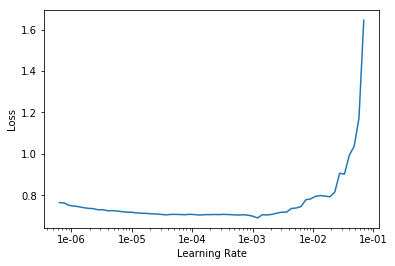

In [9]:
learner.lr_find()
learner.recorder.plot()

# Train the model for a couple of epochs.

In [10]:
learner = learner.to_fp16()
learner.fit_one_cycle(5, max_lr=3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.614905,0.406366,0.810017,10:13
1,0.331705,0.339838,0.844128,10:02
2,0.297316,0.311411,0.851468,09:54
3,0.225756,0.349627,0.851900,09:25
4,0.161780,0.370187,0.854922,09:29


# Render losses and metrics.

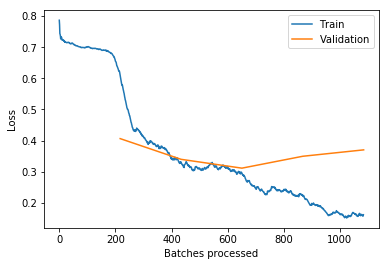

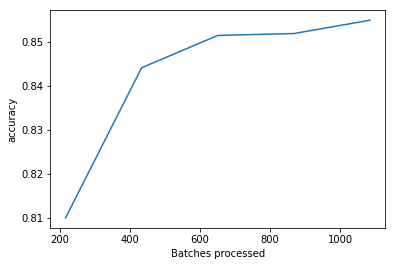

In [12]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()

# Render confusion matrix.

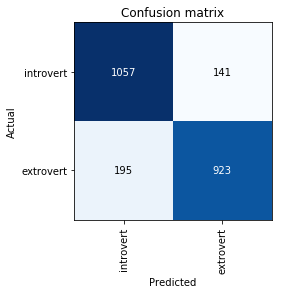

In [13]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

# Do some predictions.

In [14]:
print(learner.predict("I want to be alone. I love painting and listening to good music. I never go to parties. I feel scared of people all the time."))
print(learner.predict("Listen to me! What you have done there is excellent. Tell me more about it!"))

(Category introvert, tensor(0), tensor([0.9759, 0.0241]))
(Category extrovert, tensor(1), tensor([0.4267, 0.5733]))
